# <center> Анализ датасета о вине
    
Подготовил Потехин Андрей  
Телефон: +7 (918) 55 777 49  
Telegram: t.me/andredepoteh    
Выполнил 15.05.2023 г.  

### <center> Вводная информация
В папĸе data находятся 43 CSV файла с отзывами на различные вина.  
CSV в формате Excel с разделителем полей ";", десятичным разделителем ",", в ĸодировĸе UTF-8-
BOM.  
### <center> Описание данных  
В файлах содержатся рейтинги с отзывами (описаниями вĸусового профиля) на различные вина.  
Каждая строĸа содержит отзыв, оценĸу, стоимость и информацию о происхождении вина.  

1. entry_id (integer) - ID записи  
2. country (character) - Страна происхождения вина  
3. variety (character) - Сорт винограда  
4. winery (character) - Винодельня  
5. designation (character) - Название виноградниĸа в винодельне  
6. points (integer) - Баллы WineEnthusiast на шĸале 1-100 (публиĸуются тольĸо отзывы с баллом >=80)  
7. price (integer) - Стоимость за бутылĸу, USD  
8. province (character) - Провинция происхождения вина  
9. region (character) - Регион в провинции происхождения вина  
10. taster_name (character) - Имя автора отзыва  
11. title (character) - Заголовоĸ отзыва, ĸаĸ правило содержит винтаж (год урожая)  
12. description (character) - Описание вĸусового профиля вина от автора отзыва  
    

### <center> Часть 1: Техничесĸая

In [1]:
# Здесь импортируем необходимые библиотеки
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_regression, f_classif
from sklearn import preprocessing
from scipy import stats
import re

In [2]:
# С помощью Path из модуля pathlib мы сможем взять все названия файлов csv, которые будут в папке data
# Затем в цикле прочитаем эти файлы и "склеем" в один датафрейм под названием df
data_dir = Path('data')
df = pd.concat([pd.read_csv(f, sep=';') for f in data_dir.glob('*.csv')], ignore_index=True)

In [3]:
df.head()

,entry_id,country,description,designation,points,price,province,region,taster_name,title,variety,winery
0,119966,Argentina,Raspberry and cassis aromas are fresh and upri...,Pedernal,90,43.0,Other,San Juan,Michael Schachner,Finca Las Moras 2010 Pedernal Malbec (San Juan),Malbec,Finca Las Moras
1,119956,Argentina,Compared to the regular 2006 Malbec from Chaka...,Reserve,91,25.0,Mendoza Province,Luján de Cuyo,Michаеl Schаchnеr,Chakana 2006 Reserve Malbec (Luján de Cuyo),Malbec,Chakana
2,119950,Argentina,Andeluna's top wines tend to be ripe and plump...,Pasionado,91,55.0,Mendoza Province,Uco Valley,Michael Schachner,Andeluna 2004 Pasionado Red (Uco Valley),Red Blend,Andeluna
3,119943,Argentina,"A lively, well-made blend of Tempranillo, Malb...",B Crux,91,24.0,Mendoza Province,Uco Valley,Michаel Schаchner,O. Fournier 2005 B Crux Red (Uco Valley),Red Blend,O. Fournier
4,119939,Argentina,There is a select group of under-$20 Malbecs f...,La Madras Vineyard,91,18.0,Mendoza Province,Mendoza,Michаеl Schаchnеr,Ricardo Santos 2006 La Madras Vineyard Malbec ...,Malbec,Ricardo Santos


Посмотрим на данные, которые у нас есть

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149908 entries, 0 to 149907
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   entry_id     149908 non-null  int64  
 1   country      149908 non-null  object 
 2   description  149908 non-null  object 
 3   designation  106749 non-null  object 
 4   points       149908 non-null  int64  
 5   price        139418 non-null  float64
 6   province     149908 non-null  object 
 7   region       125516 non-null  object 
 8   taster_name  118829 non-null  object 
 9   title        149908 non-null  object 
 10  variety      149906 non-null  object 
 11  winery       149908 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 13.7+ MB


In [5]:
df.isna().sum()

entry_id           0
country            0
description        0
designation    43159
points             0
price          10490
province           0
region         24392
taster_name    31079
title              0
variety            2
winery             0
dtype: int64

В полученном датафрейме содержатся 12 столбцов и 149908 строк  
Из 12 столбцов в 3-х числовые данные, остальные - текстовые

В следующих столбцах наблюдаются пропуски:
- designation 43159 пропуска
- price 10490 пропуска
- region 24392 пропуска
- taster_name 31079 пропуск
- variety 2 пропуска

Из задания есть информация, что в данных могут наблюдаться такие проблемы 
1. Дубликаты
2. Иногда вместо латинсĸих "a", "o", "e" встречаются их ĸирриличесĸие эĸвиваленты

Испрвим это

In [6]:
# Удалим дубликаты, при этом, оставим только первый и узнаем, сколько осталось строк в датафрейме
df = df.drop_duplicates()
df.shape

(134061, 12)

In [7]:
# Функция, которая меняет киррилические символы на аналогичные латинские
def change_symbol(s):
    if type(s) == float:
        s = s
    else:
        s = s.replace('а','a')
        s = s.replace('о','o')
        s = s.replace('е','e')
    return s

In [8]:
# Проверка работоспособности функции по замене символов

s_1 = 'hellо, guys! my namе is аndrew!' # строка, в которой есть киррилица
s_2 = change_symbol(s_1) # строка, в которой киррилица заменена на латинские аналоги

alph = ('абвгдеёжзийклмнопрстуфхцчшщъыьэюя') # алфавит киррилицы

#Пройдемся по каждому символу из исследуемой строки и поищем его в алфавите, если нашли то добавляем в список
kir_in_s_1 = [i for i in s_1 if i in alph] # для строки s_1
kir_in_s_2 = [i for i in s_2 if i in alph] # для строки s_2

print(f'В строке s_1 содержатся такие символы киррилицы: {kir_in_s_1}')
print(f'В строке s_2 содержатся такие символы киррилицы: {kir_in_s_2}')


В строке s_1 содержатся такие символы киррилицы: ['о', 'е', 'а']
В строке s_2 содержатся такие символы киррилицы: []


In [9]:
# Узнаем количество уникальных значений в признаке taster_name до изменений
n_tasters_old = df.taster_name.nunique()
print(f'Количество уникальных значений в признаке taster_name = {n_tasters_old}')

Количество уникальных значений в признаке taster_name = 74


In [10]:
# Заменим ĸирриличесĸие эĸвиваленты латинсĸих символов  "a", "o", "e"
obj_cols = df.select_dtypes(exclude=[np.number]).columns.values
for col in obj_cols:
    df[col] = df[col].apply(change_symbol)

In [11]:
# Узнаем количество уникальных значений в признаке taster_name
n_tasters = df.taster_name.nunique()
print(f'Количество уникальных значений в признаке taster_name = {n_tasters}')

Количество уникальных значений в признаке taster_name = 19


До замены символов уникальных значений в признаке taster_name было 74

Продолжим исследовать данные.  

In [12]:
print('Набор описательных статистик для переменной points')
print('Среднее значение = ', round(df['points'].mean(),2))
print('Медианное значение = ', round(df['points'].median(),2))
print('Стандартное отклонение = ', round(df['points'].std(),2))
print('_'*55,'\n')

print('Набор описательных статистик для переменной price')
print('Среднее значение = ', round(df['price'].mean(),2))
print('Медианное значение = ', round(df['price'].median(),2))
print('Стандартное отклонение = ', round(df['price'].std(),2))

Набор описательных статистик для переменной points
Среднее значение =  88.46
Медианное значение =  88.0
Стандартное отклонение =  3.09
_______________________________________________________ 

Набор описательных статистик для переменной price
Среднее значение =  35.63
Медианное значение =  25.0
Стандартное отклонение =  42.91


Выделим интересующие нас признаки в отдельный датафрейм, чтобы можно было свободнее с ними работать, не меняя исходный датасет.

In [13]:
df_num = df[['price','points']]
df_num.describe()

,price,points
count,124647.000000,134061.000000
mean,35.627797,88.457710
std,42.909554,3.089574
min,4.000000,80.000000
25%,17.000000,86.000000
50%,25.000000,88.000000
75%,42.000000,91.000000
max,3300.000000,100.000000


In [14]:
# Помним о пропусках 
df_num.isna().sum()

price     9414
points       0
dtype: int64

In [15]:
# Пропусков не так уж и много (7%). Заполним их медианным значением
df_num['price'].fillna(df_num['price'].median(), inplace = True)
df_num.isna().sum()

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_6764\2892429836.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num['price'].fillna(df_num['price'].median(), inplace = True)


price     0
points    0
dtype: int64

In [16]:
print('Набор описательных статистик для переменной points')
print('Среднее значение = ', round(df_num['points'].mean(),2))
print('Медианное значение = ', round(df_num['points'].median(),2))
print('Стандартное отклонение = ', round(df_num['points'].std(),2))
print('_'*55,'\n')

print('Набор описательных статистик для переменной price')
print('Среднее значение = ', round(df_num['price'].mean(),2))
print('Медианное значение = ', round(df_num['price'].median(),2))
print('Стандартное отклонение = ', round(df_num['price'].std(),2))

Набор описательных статистик для переменной points
Среднее значение =  88.46
Медианное значение =  88.0
Стандартное отклонение =  3.09
_______________________________________________________ 

Набор описательных статистик для переменной price
Среднее значение =  34.88
Медианное значение =  25.0
Стандартное отклонение =  41.46


Опишем связь между points и price

Построим два графика: гистограмму и бохплот для исследуемых перемнных  
Гистограмма более наглядно показывает распределение признака  
На графике боксплот хорошо видно выбросы, аномалии

<center> Для переменной points

C:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


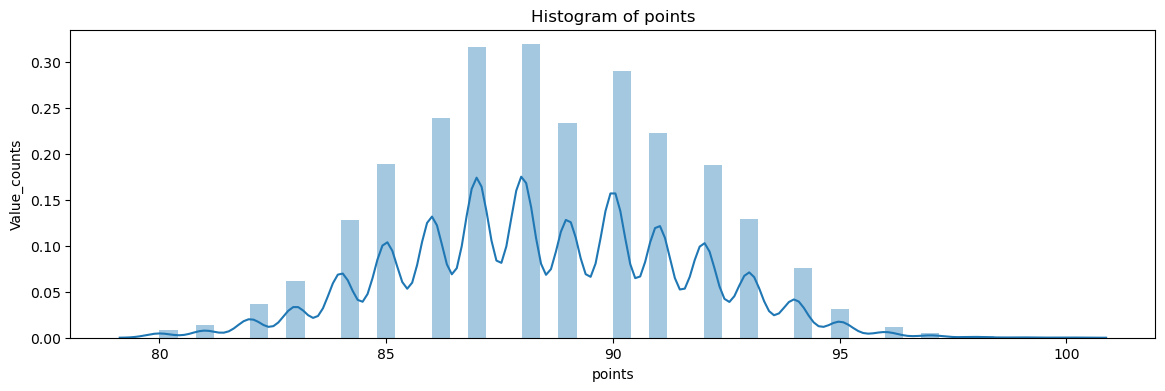

In [17]:
# Задаем область
fig, ax = plt.subplots(figsize = (14, 4))
# Строим график
sns.distplot(df_num['points'])
# Делаем подписи
plt.title(f'Histogram of points' )
plt.xlabel('points')
plt.ylabel('Value_counts')
# Показываем график
plt.show()

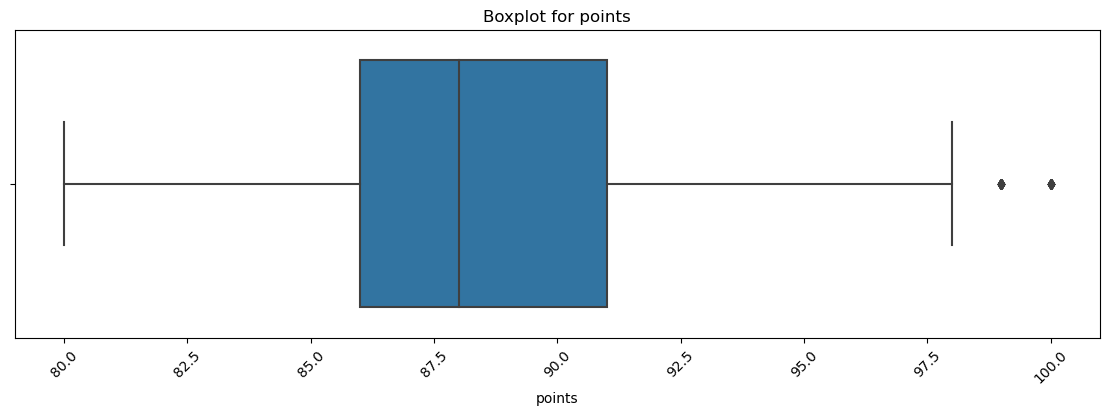

In [18]:
# Задаем область
fig, ax = plt.subplots(figsize = (14, 4))
# Строим график
sns.boxplot(x = 'points', data = df_num, ax = ax)
plt.xticks(rotation=45)
# Подписываем график
ax.set_title('Boxplot for points')
# Показываем график
plt.show()

Переменная points имеет нормальное распределение, выбросов мало

<center> Для переменной price

C:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


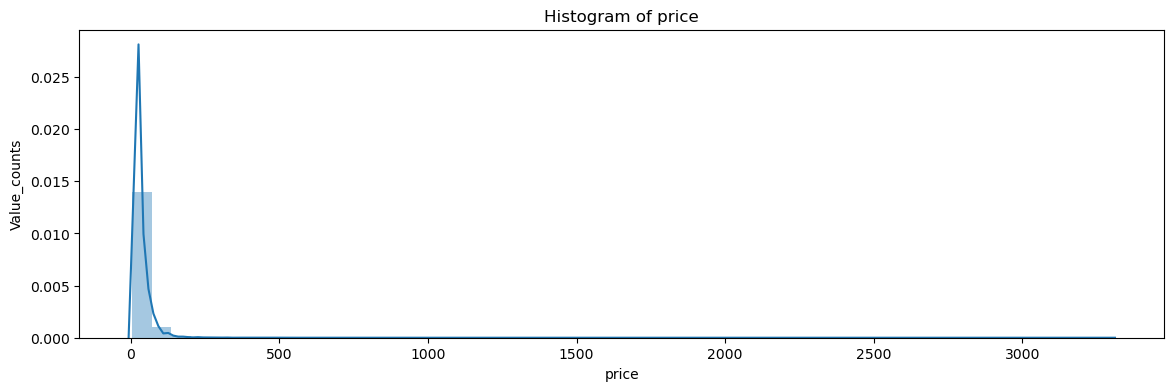

In [19]:
# Задаем область
fig, ax = plt.subplots(figsize = (14, 4))
# Строим график
sns.distplot(df_num['price'])
# Делаем подписи
plt.title(f'Histogram of price' )
plt.xlabel('price')
plt.ylabel('Value_counts')
# Показываем график
plt.show()

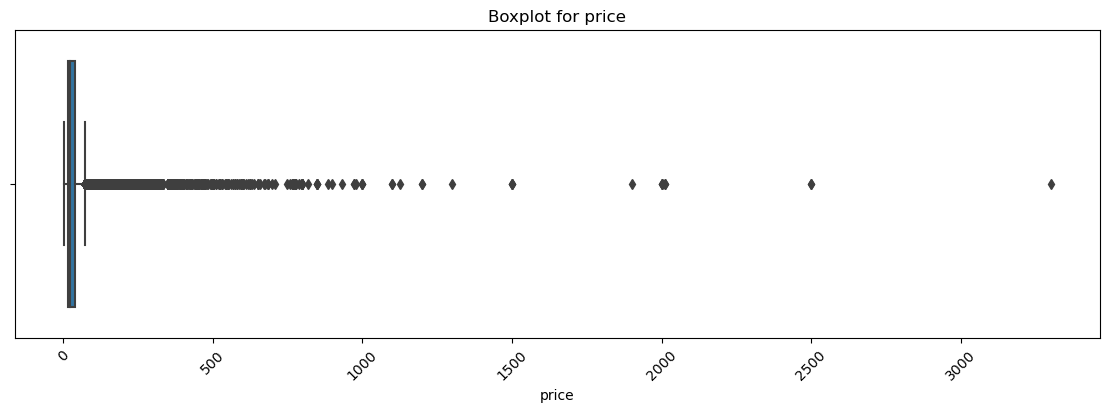

In [20]:
# Задаем область
fig, ax = plt.subplots(figsize = (14, 4))
# Строим график
sns.boxplot(x = 'price', data = df_num, ax = ax)
plt.xticks(rotation=45)
# Подписываем график
ax.set_title('Boxplot for price')
# Показываем график
plt.show()

График распределения для переменной price сильно смещен влево, наблюдается множество выбросов.  
Проведем нормализацию признака с помощью класса RobustScaler. Используем его, а не например MinMaxScaler, потому что переменная price имеет сильное смещение и много значений вне "нормального" диапазона и MinMaxScaler здесь не поможет.  

In [21]:
# выделим значения признака price в массив
X = np.array(df_num['price']).reshape(-1, 1)

# инициализируем нормализатор RobustScaler
scaler = preprocessing.RobustScaler()

# кодируем признак price
price_scaled = scaler.fit_transform(X)

# Добавим новый признак в датафрейм
df_num['price_scaled'] = price_scaled

df_num.head()

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_6764\2963984234.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num['price_scaled'] = price_scaled


,price,points,price_scaled
0,43.0,90,0.818182
1,25.0,91,0.000000
2,55.0,91,1.363636
3,24.0,91,-0.045455
4,18.0,91,-0.318182


C:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


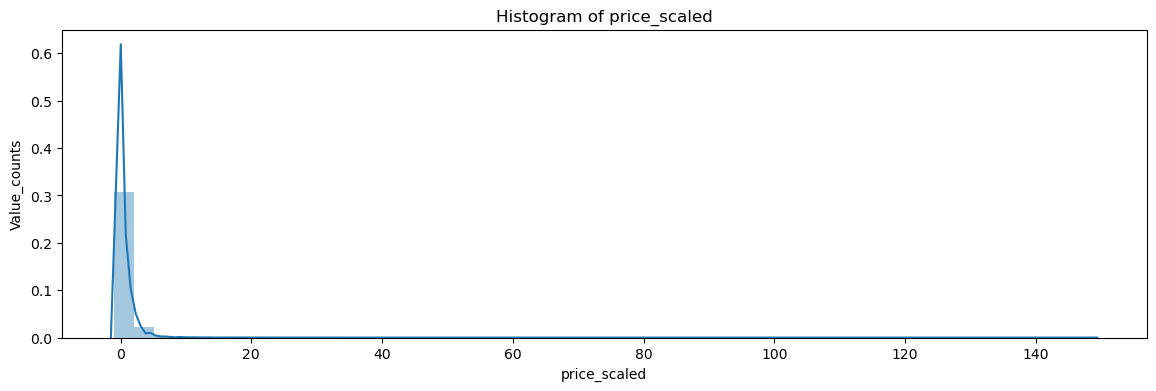

In [22]:
# Задаем область
fig, ax = plt.subplots(figsize = (14, 4))
# Строим график
sns.distplot(df_num['price_scaled'])
# Делаем подписи
plt.title(f'Histogram of price_scaled' )
plt.xlabel('price_scaled')
plt.ylabel('Value_counts')
# Показываем график
plt.show()

Ни Robust, ни MinMax, ни Standard скаляризация (нормализация) не исправили ситуацию с нормализацией распределения признака.  
А корреляцию Пирсона не следует применять для признаков с не нормальным распределением.  
Рассмотрим два варианта:  
1. Посмотрим, сколько значений цены делает распределение не нормальным. Если их немного, как вариант, попробуем без них.  
2. Использовать методы ранговой корреляции 

In [23]:
print(len(df_num))
print(len(df_num[df_num['price'] > 91]))

134061
5013


Значений признака price больше чем "91" всего 5% от общего количества данных.  
Попробуем построить корреляцию без них.

C:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


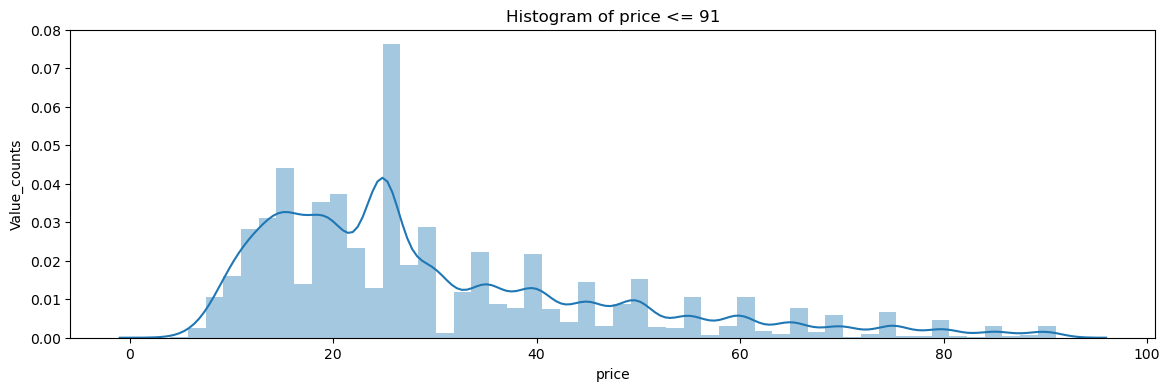

In [24]:
# Задаем область
fig, ax = plt.subplots(figsize = (14, 4))
# Строим график
sns.distplot(df_num[df_num['price'] <= 91]['price'])
# Делаем подписи
plt.title(f'Histogram of price <= 91' )
plt.xlabel('price')
plt.ylabel('Value_counts')
# Показываем график
plt.show()

Все равно распределение не кажется нормальным.  

Попробуем логарифмирование

C:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


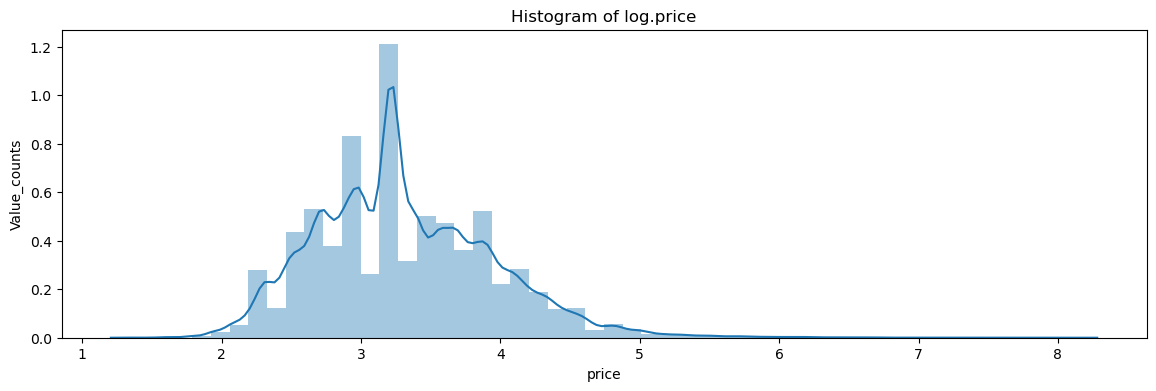

In [25]:
# Задаем область
fig, ax = plt.subplots(figsize = (14, 4))
# Строим график
sns.distplot(np.log(df_num['price']))
# Делаем подписи
plt.title(f'Histogram of log.price' )
plt.xlabel('price')
plt.ylabel('Value_counts')
# Показываем график
plt.show()

Уже лучше, но все еще смещение есть.  

Посмотрим значение различных вариантов корреляции

In [26]:
# Как базовую корреляцию для числовых признаков рассмотрим корреляцию Пирсона
pirs = round(df_num['points'].corr(df_num['price']),2)

# Посчитаем также корреляцию Пирсона для нормализованных и логаримированных значений признака price
pirs_scaled = round(df_num['points'].corr(df_num['price_scaled']),2)
pirs_log = round(df_num['points'].corr(np.log(df_num['price'])),2)

# Посмотрим ранговые корреляции Спирмена и Кендалла
spear = round(df_num['points'].corr(df_num['price'], method = 'spearman'),2)
kend = round(df_num['points'].corr(df_num['price'], method = 'kendall'),2)

print(f'Корреляция Пирсона для признаков points и price составила: {pirs}')
print(f'Корреляция Пирсона для признаков points и price нормализованного составила: {pirs_scaled}')
print(f'Корреляция Пирсона для признаков points и price логарифмированного: {pirs_log}')
print(f'Корреляция Спирмена для признаков points и price составила: {spear}')
print(f'Корреляция Кендалла для признаков points и price составила: {kend}')

Корреляция Пирсона для признаков points и price составила: 0.4
Корреляция Пирсона для признаков points и price нормализованного составила: 0.4
Корреляция Пирсона для признаков points и price логарифмированного: 0.6
Корреляция Спирмена для признаков points и price составила: 0.59
Корреляция Кендалла для признаков points и price составила: 0.44


Корреляция Пирсона с учетом логарифмизации признака price (для уменьшения дисперсии), а также корреляция Спирмена показывают, что между признаками points и price достаточно высокая взаимосвязь.  

Посмотрим на значение p-value

In [27]:
points = np.array(df_num['points'])
price = np.array(df_num['price'])

d_points = round(np.var(points),2)
d_price = round(np.var(price),2)
print(f'Дисперсии признаков points и price: {d_points} и {d_price} соответственно')

Дисперсии признаков points и price: 9.55 и 1719.3 соответственно


In [28]:
# Воспользуемся pearsonr из модуля stats
pv_p = round(stats.pearsonr(points, price)[1], 4)
print(f'p-value пр Пирсону для переменных points и price составило {pv_p}')
print('_'*50)

# функция ttest_ind 
print('Результаты ttest:')
print(stats.ttest_ind(points, price, equal_var = False)) # equal_var = False, потому что дисперсии признаков сильно отличаются


p-value пр Пирсону для переменных points и price составило 0.0
__________________________________________________
Результаты ttest:
Ttest_indResult(statistic=471.7848856788891, pvalue=0.0)


In [29]:
res = stats.linregress(points, price)
res._asdict()

{'slope': 5.306757676102373,
 'intercept': -434.5421349204304,
 'rvalue': 0.39541295336114657,
 'pvalue': 0.0,
 'stderr': 0.03366752341734903,
 'intercept_stderr': 2.979967971156009}

По рассчитанному значению корреляции, мы видим, что связь между points и price есть, а по значению p-value = 0 мы можем понять, что корреляция возникла не случайно.  
То есть существует некая функция, которая может описать связь между этими переменными.

Для визуализации связи между переменными построим диаграмму рассеивания

In [30]:
# Для отрисовки линии тренда
fx = np.array([points.min(), points.max()])
fy = res.intercept + res.slope * fx

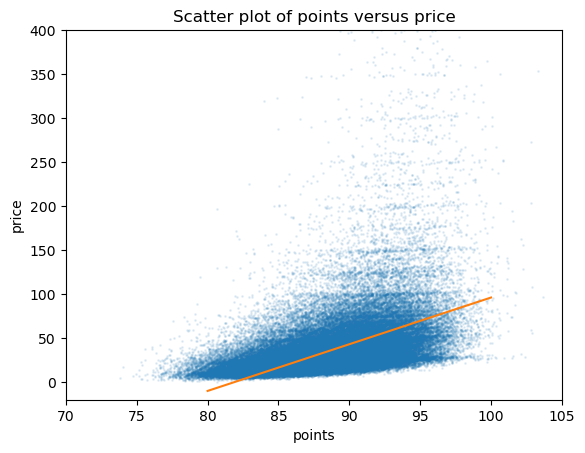

In [31]:
points = df_num['points']
price = df_num['price']

# Добавим шум для того, чтобы график не отображался столбцами, а визуализировал взаимосвязь 
noise = np.random.normal(0, 2, size = len(df))

points_jitter = points + noise
price_jitter = price + noise

plt.plot(points_jitter, price_jitter, 'o', alpha = 0.1, markersize = 1)

# Добавим линию тренда
plt.plot(fx, fy, '-')

# Посмотрим на график в масштабе, 
# потому что из-за распределения цены и высоких значений - график превращается в непонятную полоску

plt.xlim([70, 105])
plt.ylim([-20, 400])

# Добавим подписи
plt.xlabel('points')
plt.ylabel('price')
plt.title('Scatter plot of points versus price')

# Показываем график
plt.show()

Можем видеть, что общая тенденция такая - с увеличением цены количество низких балов все меньше

Посмотреим более подробно, что происходит со средним значением баллов на некоторых диапазонах цен

In [32]:
points_25_price = round(df_num[df_num['price'] <= 25]['points'].mean(),0)
points_40_price = round(df_num[(df_num['price'] > 25) & (df_num['price'] <= 40)]['points'].mean(),0)
points_100_price = round(df_num[(df_num['price'] > 40) & (df_num['price'] <= 100)]['points'].mean(),0)
points_200_price = round(df_num[(df_num['price'] > 100) & (df_num['price'] <= 200)]['points'].mean(),0)
points_500_price = round(df_num[(df_num['price'] > 200) & (df_num['price'] <= 500)]['points'].mean(),0)
points_1000_price = round(df_num[(df_num['price'] > 500) & (df_num['price'] <= 1000)]['points'].mean(),0)
points_max_price = round(df_num[df_num['price'] > 1000]['points'].mean(),0)

print(f'Средняя оценка при цене 25 и меньше составляет {points_25_price}')
print(f'Средняя оценка при цене от 25 до 40 составляет {points_40_price}')
print(f'Средняя оценка при цене от 40 до 100 составляет {points_100_price}')
print(f'Средняя оценка при цене от 100 до 200 составляет {points_200_price}')
print(f'Средняя оценка при цене от 200 до 500 составляет {points_500_price}')
print(f'Средняя оценка при цене от 500 до 1000 составляет {points_1000_price}')
print(f'Средняя оценка при цене от 1000 и выше составляет {points_max_price}')

Средняя оценка при цене 25 и меньше составляет 87.0
Средняя оценка при цене от 25 до 40 составляет 89.0
Средняя оценка при цене от 40 до 100 составляет 91.0
Средняя оценка при цене от 100 до 200 составляет 93.0
Средняя оценка при цене от 200 до 500 составляет 94.0
Средняя оценка при цене от 500 до 1000 составляет 96.0
Средняя оценка при цене от 1000 и выше составляет 96.0


То есть, мы видим, что рейтинг стабильно растет, но когда цена достигает определенного уровня (значение в районе 200), то рост значения рейтинга замедляется, то есть цена растет быстро, а рейтинг нет.  
После цены в 500 единиц - рост и вовсе практически останавливается.  

In [33]:
df_num['price'].describe()

count    134061.000000
mean         34.881494
std          41.464553
min           4.000000
25%          18.000000
50%          25.000000
75%          40.000000
max        3300.000000
Name: price, dtype: float64

Посмотрим еще раз статистику признака price.

Преобразуем этот признак в категориальный, чтобы посмотреть визуально какие значения баллов (points) в разных категориях цен

In [34]:
# Функция, которая преобразует признак прайс в категориальный
def change_price_to_cat(i):
    if i <= 40:
        i = '40 и меньше'
    elif 40 < i <= 100:
        i = 'больше 40 до 100'
    elif 100 < i <= 500:
        i = 'больше 100 до 500'
    else: 
        i = 'больше 500'
    return i

In [35]:
df_num_cat = df_num.copy()
df_num_cat['price'] = df_num_cat['price'].apply(change_price_to_cat)

In [36]:
df_num_cat['price'].value_counts()

40 и меньше          101618
больше 40 до 100      28803
больше 100 до 500      3530
больше 500              110
Name: price, dtype: int64

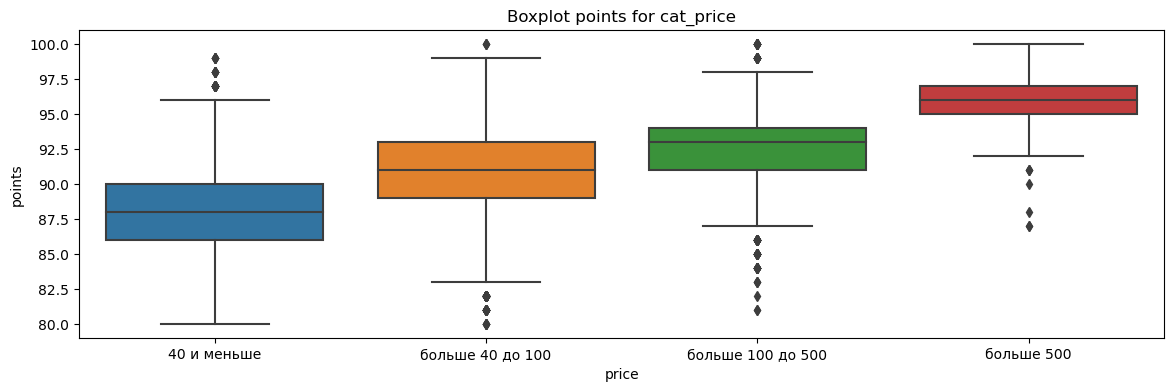

In [37]:
# Задаем область
fig, ax = plt.subplots(figsize = (14, 4))
# Строим график
sns.boxplot(x = 'price', y = 'points', data = df_num_cat, ax = ax, order = df_num_cat['price'].value_counts().index)
# Подписываем график
ax.set_title('Boxplot points for cat_price')
# Показываем график
plt.show()

Отчетливо видно, как с ростом цены становится все меньше низких балов и все больше высоких.  
Все статистические показатели растут

При этом, нельзя забывать, что выборка вин из дешевой категории (менее 100) - это 97,3% всех отзывов в датасете.  
Для более корректного использования нужно увеличить количество оцененных экземпляров из категории дорогих вин.

### <center> Часть 2: Творческая

Заĸазчиĸ сформулировал задачи таĸ:  
- Каĸ зовут ТОП-5 самых продуĸтивных авторов отзывов (по числу отзывов).
- Вина из ĸаĸих стран ĸаждый из ТОП-5 в основном оценивает.
- Не интересны ĸейсы, если он оценил одно вино отĸуда-то из необычного места.
- Отличаются ли ценовые диапазон вин, ĸоторые оценивает ĸаждый из ТОП-5? Хочется увидеть наглядно.

In [38]:
print('ТОП-5 самых продуĸтивных авторов с количеством отзывов:')
display(df['taster_name'].value_counts()[:5].to_frame())
print('_'*100)

top_5_names = list(df['taster_name'].value_counts()[:5].to_dict())
print(f'ТОП-5 самых продуĸтивных авторов списком:\n\n{top_5_names}')

ТОП-5 самых продуĸтивных авторов с количеством отзывов:


,taster_name
Roger Voss,27253
Michael Schachner,16273
Kerin O’Keefe,10795
Paul Gregutt,10276
Virginie Boone,10039


____________________________________________________________________________________________________
ТОП-5 самых продуĸтивных авторов списком:

['Roger Voss', 'Michael Schachner', 'Kerin O’Keefe', 'Paul Gregutt', 'Virginie Boone']


In [39]:
Roger_Voss_country = df[df['taster_name'] == 'Roger Voss']['country'].value_counts().to_dict()
Michael_Schachner_country = df[df['taster_name'] == 'Michael Schachner']['country'].value_counts().to_dict()
Kerin_OKeefe_country = df[df['taster_name'] == 'Kerin O’Keefe']['country'].value_counts().to_dict()
Paul_Gregutt_country = df[df['taster_name'] == 'Paul Gregutt']['country'].value_counts().to_dict()
Virginie_Boone_country = df[df['taster_name'] == 'Virginie Boone']['country'].value_counts().to_dict()

print(f'Наиболее популярные страны для Roger Voss \n{list(Roger_Voss_country)[:2]}')
print('\n','-'*45,'\n')
print(f'Наиболее популярные страны для Michael Schachner \n{list(Michael_Schachner_country)[:3]}')
print('\n','-'*45,'\n')
print(f'Наиболее популярные страны для Kerin O’Keefe \n{list(Kerin_OKeefe_country)}')
print('\n','-'*45,'\n')
print(f'Наиболее популярные страны для Paul Gregutt \n{list(Paul_Gregutt_country)[:1]}')
print('\n','-'*45,'\n')
print(f'Наиболее популярные страны для Virginie Boone \n{list(Virginie_Boone_country)}')


Наиболее популярные страны для Roger Voss 
['France', 'Portugal']

 --------------------------------------------- 

Наиболее популярные страны для Michael Schachner 
['Spain', 'Chile', 'Argentina']

 --------------------------------------------- 

Наиболее популярные страны для Kerin O’Keefe 
['Italy']

 --------------------------------------------- 

Наиболее популярные страны для Paul Gregutt 
['US']

 --------------------------------------------- 

Наиболее популярные страны для Virginie Boone 
['US']


In [40]:
df_top = df[(df['taster_name'] == top_5_names[0]) | 
           (df['taster_name'] == top_5_names[1]) |
           (df['taster_name'] == top_5_names[2]) |
           (df['taster_name'] == top_5_names[3]) |
           (df['taster_name'] == top_5_names[4])]

In [41]:
# Посмотрим на статистические данные каждого из ТОП_5 дегустатора 
display(df_top.groupby('taster_name')['price'].describe())

,count,mean,std,min,25%,50%,75%,max
taster_name,,,,,,,,
Kerin O’Keefe,9886.0,42.421809,39.724024,6.0,20.0,30.0,51.0,800.0
Michael Schachner,16070.0,25.286870,29.320690,4.0,12.0,17.0,25.0,770.0
Paul Gregutt,10239.0,33.727219,19.174157,5.0,20.0,29.0,42.0,275.0
Roger Voss,21447.0,39.633748,74.750047,5.0,15.0,23.0,40.0,3300.0
Virginie Boone,10009.0,46.946148,33.422309,7.0,25.0,39.0,58.0,625.0


Среднее и медианное значения выделяются 
- у Michael Schachner - у него они ниже, чем у других
- у Virginie Boone - у него они выше, чем у других  

При этом, что характерно для одного и не характерно для других:
- Paul Gregutt не оценивал вина дороже 275 
- Roger Voss - единственный, кто оценивал вина дороже 800

Наибольшей вклад в оценку вин внес Roger Voss - почти в два раза больше чем среднее количество отзывов.  
Видимо, как раз за счет дорогих вин.

Визуализируем это с помощью ящика с усами

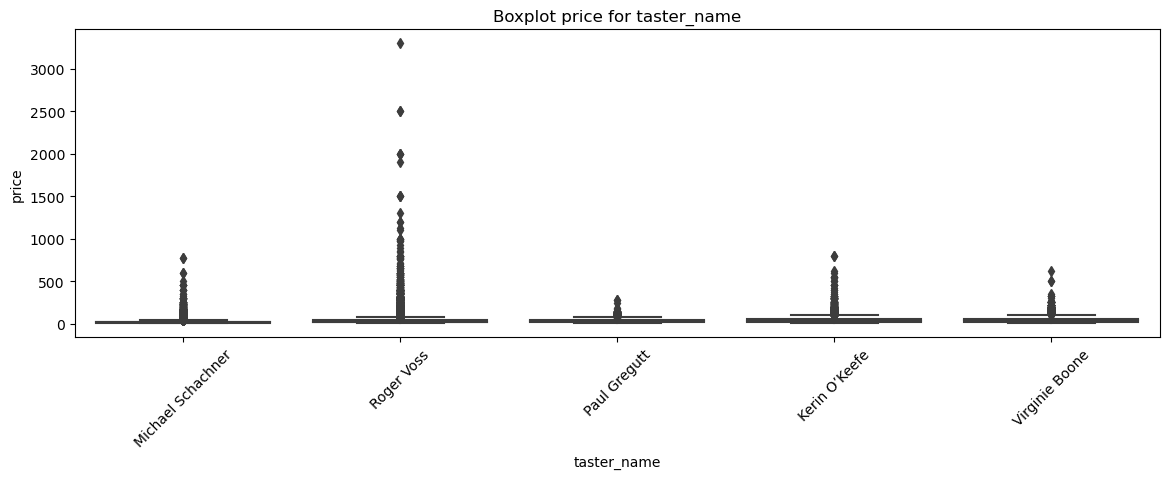

In [42]:
# Задаем область
fig, ax = plt.subplots(figsize = (14, 4))
# Строим график
sns.boxplot(x = 'taster_name', y = 'price', data = df_top, ax = ax)
plt.xticks(rotation = 45)
# Подписываем график
ax.set_title('Boxplot price for taster_name')
# Показываем график
plt.show()

В виду того, что диапазон цен на вина, которые исследовали авторы (особенно Roger Voss) слишком большие, а основной диапазон все равно находится в низких ценах (видно по медианной цене у каждого автора) - график стал нечитаемым.  
Для чуть лучшей визуализации предлагается отсечь значения цен выше, например 200

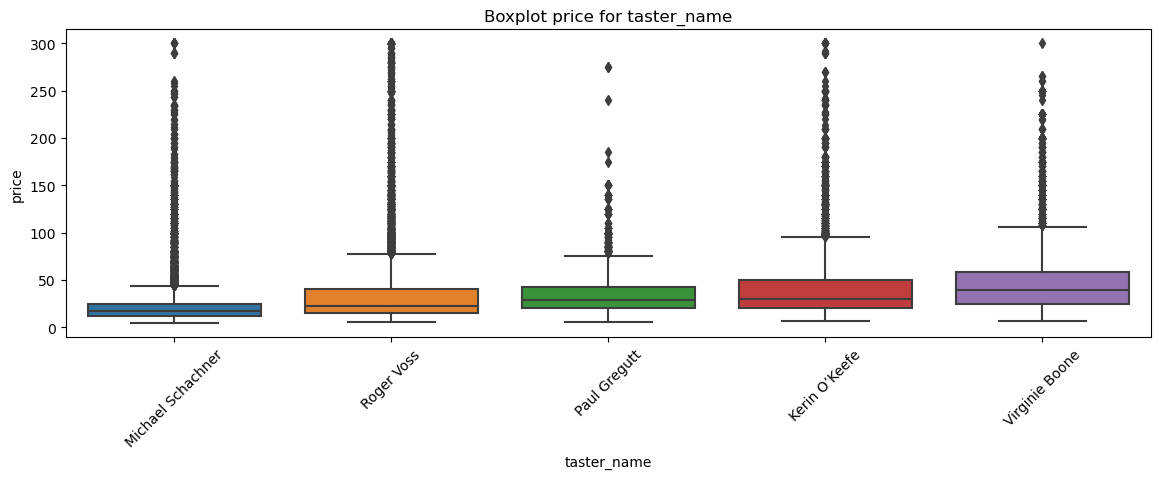

In [43]:
# Задаем область
fig, ax = plt.subplots(figsize = (14, 4))
# Строим график
sns.boxplot(x = 'taster_name', y = 'price', data = df_top[df_top['price'] <= 300], ax = ax)
plt.xticks(rotation = 45)
# Подписываем график
ax.set_title('Boxplot price for taster_name')
# Показываем график
plt.show()

### <center> ДОПОЛНИТЕЛЬНО

Заĸазчиĸу очень интересно узнать - что в вине "работает" на высоĸий рейтинг (90+).  
Интересно, ĸаĸие есть марĸеры высоĸого рейтинга в описании вĸуса и в происхождении вина.

Чтобы ответить на эти вопросы - вернемся к исходному датафрейму и преобразуем некоторые категориальные признаки в числовые, заполним или удалим пропуски, возможно добавим какие-то признаки, чтобы точнее уловить взаимосвязи, отобрать важные признаки.  

А также исследуем признак description для выявления маркеров в описании вĸуса вина

In [44]:
df_pro = df.copy()
df_pro = df_pro.drop('entry_id', axis = 1)
df_pro.head()

,country,description,designation,points,price,province,region,taster_name,title,variety,winery
0,Argentina,Raspberry and cassis aromas are fresh and upri...,Pedernal,90,43.0,Other,San Juan,Michael Schachner,Finca Las Moras 2010 Pedernal Malbec (San Juan),Malbec,Finca Las Moras
1,Argentina,Compared to the regular 2006 Malbec from Chaka...,Reserve,91,25.0,Mendoza Province,Luján de Cuyo,Michael Schachner,Chakana 2006 Reserve Malbec (Luján de Cuyo),Malbec,Chakana
2,Argentina,Andeluna's top wines tend to be ripe and plump...,Pasionado,91,55.0,Mendoza Province,Uco Valley,Michael Schachner,Andeluna 2004 Pasionado Red (Uco Valley),Red Blend,Andeluna
3,Argentina,"A lively, well-made blend of Tempranillo, Malb...",B Crux,91,24.0,Mendoza Province,Uco Valley,Michael Schachner,O. Fournier 2005 B Crux Red (Uco Valley),Red Blend,O. Fournier
4,Argentina,There is a select group of under-$20 Malbecs f...,La Madras Vineyard,91,18.0,Mendoza Province,Mendoza,Michael Schachner,Ricardo Santos 2006 La Madras Vineyard Malbec ...,Malbec,Ricardo Santos


In [45]:
# Функция, которая в категориальных признаках будет считать количество значений какждой категории
# и создавать признак в датафрейме, в который будет подставлять соответствующие значения

def create_count_from_cat(df, col):
    count_col = df[col].value_counts().to_dict()
    df['count_'+col] = df[col].map(count_col)

Выберем категориальные признаки

In [46]:
cat_features = df_pro.select_dtypes(exclude=[np.number]).columns.values
cat_features = np.delete(cat_features, [1,6])
cat_features

array(['country', 'designation', 'province', 'region', 'taster_name',
       'variety', 'winery'], dtype=object)

Преобразуем их в числовые, путем подсчета количества объектов в каждой категории признака и создания нового признака, в котором напротив категории будет проставляться количество ее экземпляров.

In [47]:
for col in cat_features:
    create_count_from_cat(df_pro, col)
    df_pro.drop(col, axis = 1, inplace = True)
df_pro.head()

,description,points,price,title,count_country,count_designation,count_province,count_region,count_taster_name,count_variety,count_winery
0,Raspberry and cassis aromas are fresh and upri...,90,43.0,Finca Las Moras 2010 Pedernal Malbec (San Juan),4095,1.0,584,78.0,16273.0,2831.0,22
1,Compared to the regular 2006 Malbec from Chaka...,91,25.0,Chakana 2006 Reserve Malbec (Luján de Cuyo),4095,2081.0,3511,196.0,16273.0,2831.0,22
2,Andeluna's top wines tend to be ripe and plump...,91,55.0,Andeluna 2004 Pasionado Red (Uco Valley),4095,7.0,3511,280.0,16273.0,9190.0,45
3,"A lively, well-made blend of Tempranillo, Malb...",91,24.0,O. Fournier 2005 B Crux Red (Uco Valley),4095,8.0,3511,280.0,16273.0,9190.0,63
4,There is a select group of under-$20 Malbecs f...,91,18.0,Ricardo Santos 2006 La Madras Vineyard Malbec ...,4095,5.0,3511,2487.0,16273.0,2831.0,19


In [48]:
# Выделим в отдельный признак год производства вина
def find_year(s):
    result = re.search(r'\d{4}', s)
    return int(result.group()) if result else 0

df_pro['year'] = df_pro['title'].apply(find_year)
df_pro.head()

,description,points,price,title,count_country,count_designation,count_province,count_region,count_taster_name,count_variety,count_winery,year
0,Raspberry and cassis aromas are fresh and upri...,90,43.0,Finca Las Moras 2010 Pedernal Malbec (San Juan),4095,1.0,584,78.0,16273.0,2831.0,22,2010
1,Compared to the regular 2006 Malbec from Chaka...,91,25.0,Chakana 2006 Reserve Malbec (Luján de Cuyo),4095,2081.0,3511,196.0,16273.0,2831.0,22,2006
2,Andeluna's top wines tend to be ripe and plump...,91,55.0,Andeluna 2004 Pasionado Red (Uco Valley),4095,7.0,3511,280.0,16273.0,9190.0,45,2004
3,"A lively, well-made blend of Tempranillo, Malb...",91,24.0,O. Fournier 2005 B Crux Red (Uco Valley),4095,8.0,3511,280.0,16273.0,9190.0,63,2005
4,There is a select group of under-$20 Malbecs f...,91,18.0,Ricardo Santos 2006 La Madras Vineyard Malbec ...,4095,5.0,3511,2487.0,16273.0,2831.0,19,2006


In [49]:
len(df_pro[df_pro['year'] == 0])

4749

4749 (3,5% данных) значений признака год = 0, т.е. там не нашелся год производства.. посмотрим

In [50]:
df_pro[df_pro['year'] == 0]['price'].describe()

count    4254.000000
mean       32.065820
std        38.242939
min         4.000000
25%        15.000000
50%        22.000000
75%        40.000000
max      1000.000000
Name: price, dtype: float64

Распределение примерно такое же как и во всем датасете, можно удалить эти строки без потери качества дальнейшей оценки.  
Возможно есть решение и лучше, нужно подумать..  
Как вариант, посмотреть, заменить нули медианными значениями года производства для разных ценовых категорий. 

In [51]:
df_pro = df_pro[df_pro['year'] != 0].reset_index(drop= True)
df_pro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129312 entries, 0 to 129311
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   description        129312 non-null  object 
 1   points             129312 non-null  int64  
 2   price              120393 non-null  float64
 3   title              129312 non-null  object 
 4   count_country      129312 non-null  int64  
 5   count_designation  91175 non-null   float64
 6   count_province     129312 non-null  int64  
 7   count_region       107531 non-null  float64
 8   count_taster_name  105412 non-null  float64
 9   count_variety      129311 non-null  float64
 10  count_winery       129312 non-null  int64  
 11  year               129312 non-null  int64  
dtypes: float64(5), int64(5), object(2)
memory usage: 11.8+ MB


In [52]:
df_pro.isna().sum()

description              0
points                   0
price                 8919
title                    0
count_country            0
count_designation    38137
count_province           0
count_region         21781
count_taster_name    23900
count_variety            1
count_winery             0
year                     0
dtype: int64

Пропусков в датасете достаточно много, заполнять их просто медианой, средним или другими обычными способами не имеет смысла - данные будут искажены.  
Нужно заполнять логически, исходя из значений других признаков.  
Например, Регион заполнять исходя из Провинции.  
Составить словари, где будут Регион будет сопоставлен конкретной провинции (или наоборот) и заполнять таким образом.

Сейчас не буду, т.к. цель не в этом, для оценки важности признаков данных будет достаточно

In [53]:
df_pro = df_pro.dropna(subset = ['count_taster_name', 'count_region', 'count_designation', 'price'])
df_pro.isna().sum()

description          0
points               0
price                0
title                0
count_country        0
count_designation    0
count_province       0
count_region         0
count_taster_name    0
count_variety        0
count_winery         0
year                 0
dtype: int64

In [54]:
X_train = df_pro.select_dtypes(include=[np.number]).drop('points', axis = 1)
y_train = df_pro['points']

In [55]:
columns_train = X_train.columns

In [56]:
def get_hist_num(df, col):
    # Задаем область
    fig, ax = plt.subplots(figsize = (14, 4))
    # Строим график
    sns.distplot(df[col])
    # Делаем подписи
    plt.title(f'Histogram of {col}' )
    plt.xlabel(col)
    plt.ylabel('Value_counts')
    # Показываем график
    plt.show()

C:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


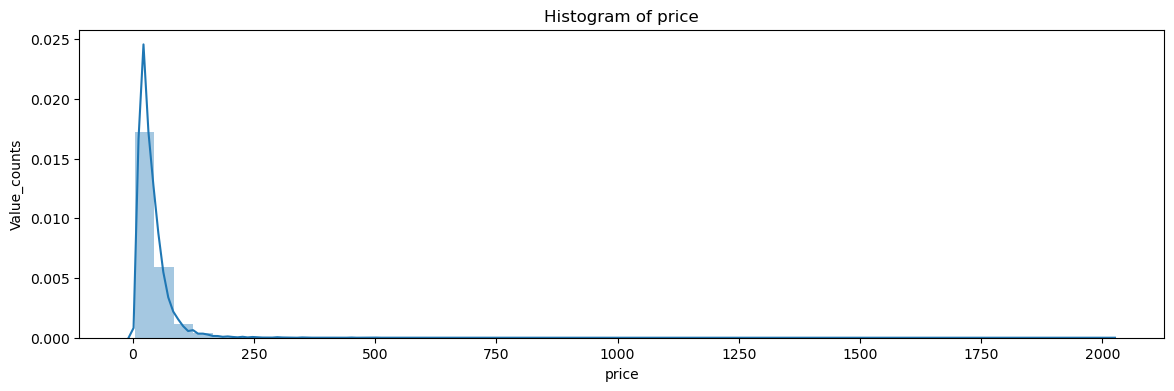

C:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


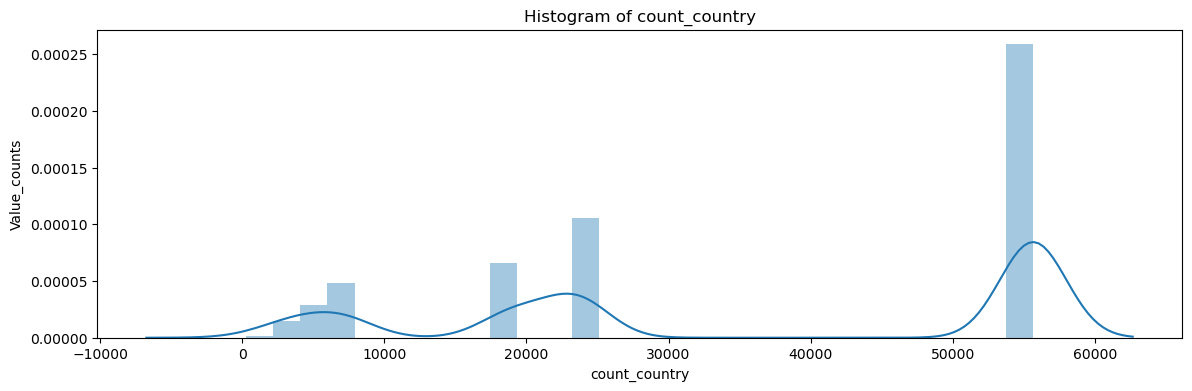

C:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


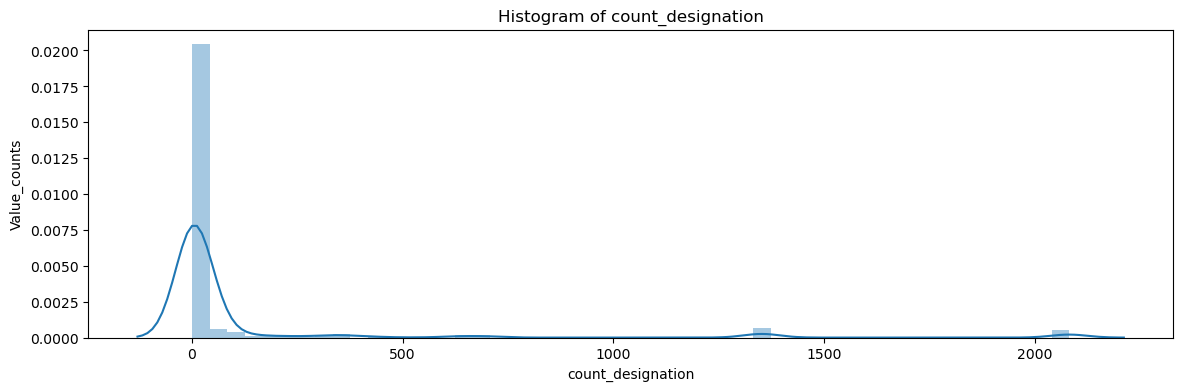

C:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


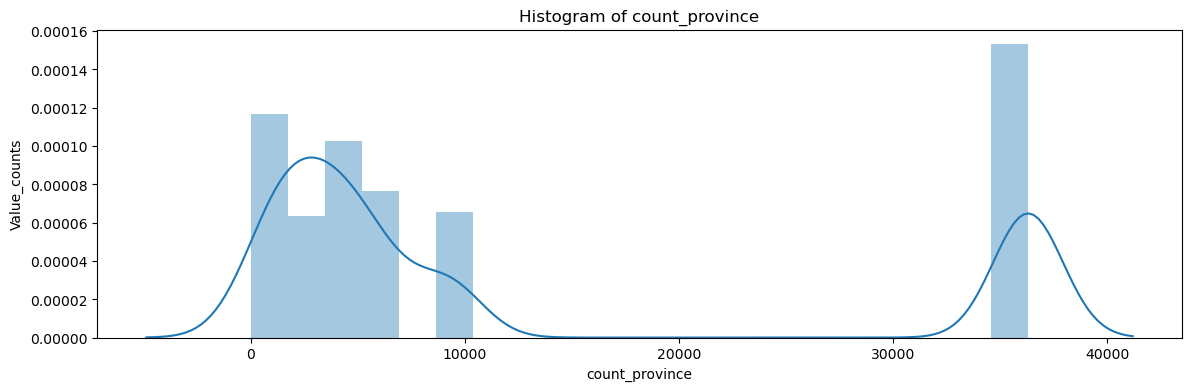

C:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


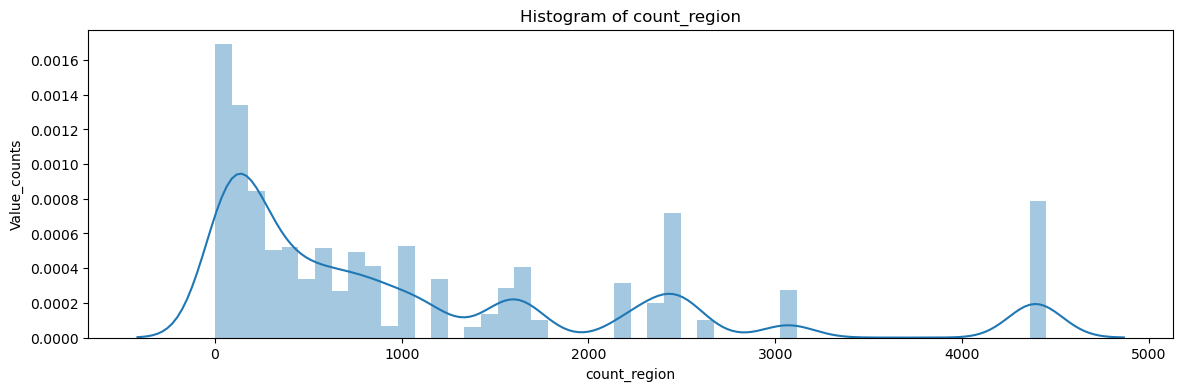

C:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


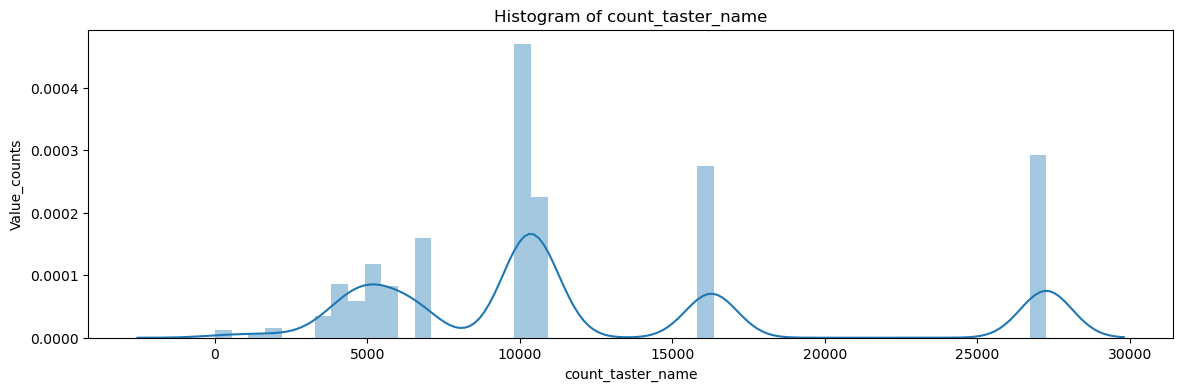

C:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


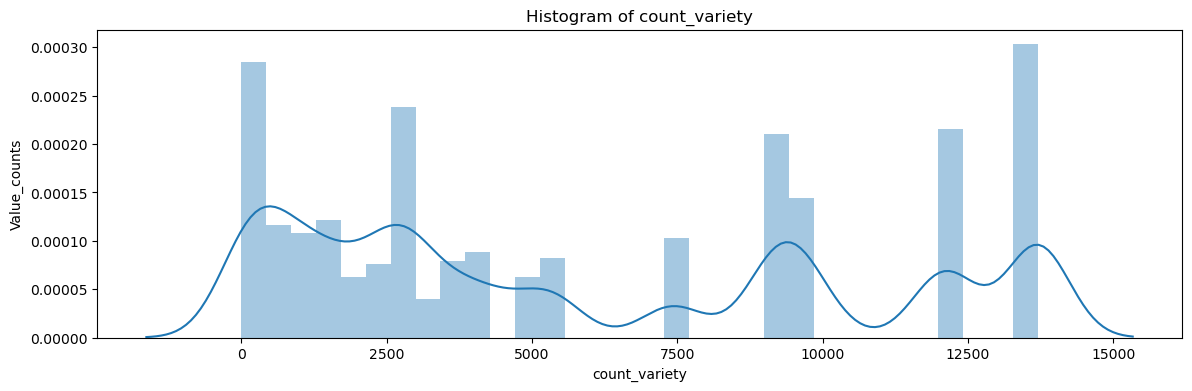

C:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


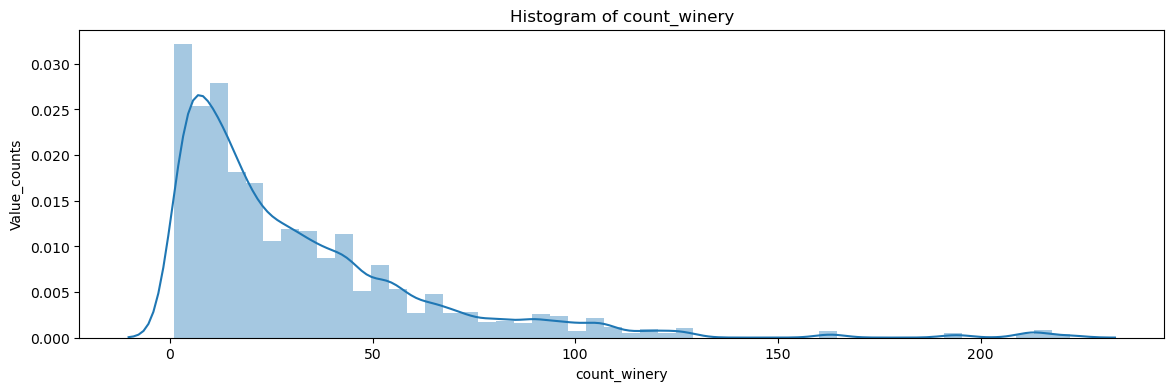

C:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


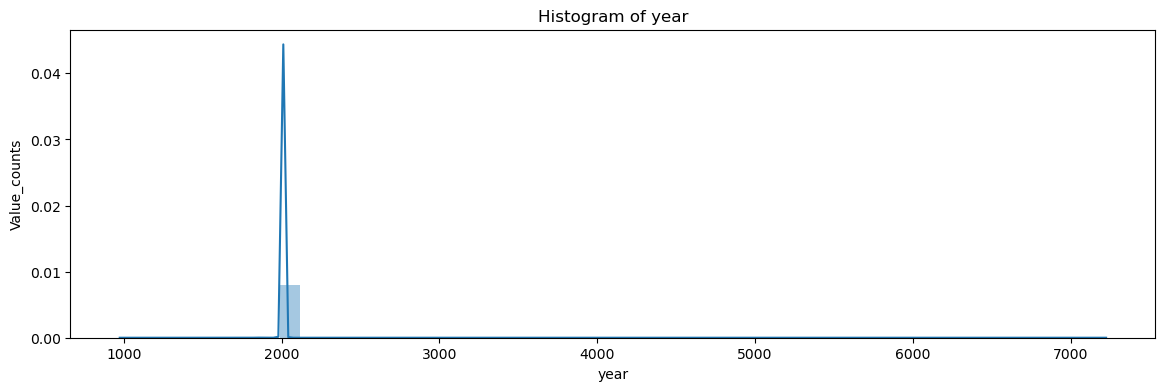

In [57]:
for col in columns_train:
    get_hist_num(X_train, col)

In [58]:
# Распределение не нормальное, поэтому посмотрим на корреляцию Спирмена
for col in columns_train:
    k_s = round(X_train[col].corr(y_train, method = 'spearman'),2)
    print(f'Корреляция с целевой переменной признака {col} составила {k_s}')

Корреляция с целевой переменной признака price составила 0.62
Корреляция с целевой переменной признака count_country составила 0.17
Корреляция с целевой переменной признака count_designation составила 0.02
Корреляция с целевой переменной признака count_province составила 0.19
Корреляция с целевой переменной признака count_region составила 0.1
Корреляция с целевой переменной признака count_taster_name составила -0.09
Корреляция с целевой переменной признака count_variety составила 0.16
Корреляция с целевой переменной признака count_winery составила 0.19
Корреляция с целевой переменной признака year составила 0.05


Воспользуемся некоторыми методами отбора признаков библиотеки sklearn

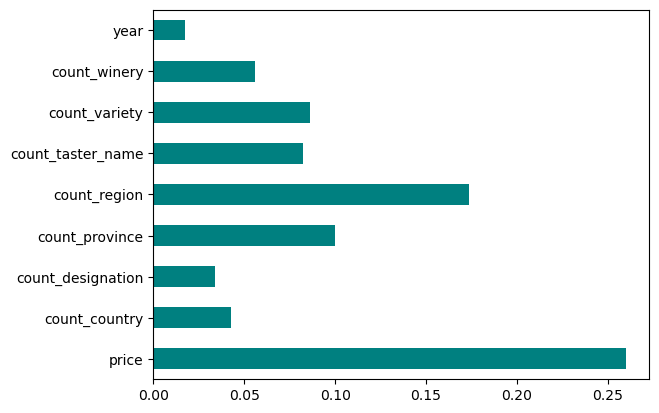

In [59]:
importances = mutual_info_classif(X_train, y_train)
feature_importances = pd.Series(importances, X_train.columns)
feature_importances.plot(kind = 'barh', color = 'teal')
plt.show()

In [60]:
selector = SelectKBest(f_regression, k=3)
selector.fit(X_train, y_train)
 
pirs_features = selector.get_feature_names_out()
pirs_features

array(['price', 'count_country', 'count_province'], dtype=object)

In [61]:
selector = SelectKBest(f_classif, k=3)
selector.fit(X_train, y_train)
 
anova_features = selector.get_feature_names_out()
anova_features

array(['price', 'count_country', 'count_province'], dtype=object)

Разные статистические методы отбора важных признаков дали разный результат, но общая тендеция такая:
- price (Цена)
- province (Провинция происхождения вина)
- region (Регион в провинции происхождения вина)
- winery (Винодельня)

То есть, в основном важна провинция и регион происхождения вина.  
Винодельни важны, потому что, скорее всего, они как раз и работают с определенной провинцией и регионом.  
Ну и конечно решает цена

Сделаем еще несколько ТОПов на основе баллов
- Провинции
- Регионы
- Винодельни

In [62]:
cols = ['province', 'region', 'winery']
for col in cols:
    top = df.groupby(col)['points'].median().to_frame()
    print(f'ТОП-10 из признака {col} по медианному значению баллов:')
    display(top.sort_values(by = 'points', ascending=False).head(5))
    print('_'*40,'\n')

ТОП-10 из признака province по медианному значению баллов:


,points
province,
Südburgenland,94.0
Madeira,94.0
Traisental,92.0
Leithaberg,92.0
Wachau,92.0


________________________________________ 

ТОП-10 из признака region по медианному значению баллов:


,points
region,
Bienvenues Bâtard-Montrachet,97.0
Bolgheri Sassicaia,97.0
Corton-Pougets,96.5
Napa-Monterey-Mendocino,96.0
Montrachet,96.0


________________________________________ 

ТОП-10 из признака winery по медианному значению баллов:


,points
winery,
Araujo,98.0
Château d'Yquem,97.0
Salon,97.0
Tenuta dell'Ornellaia,97.0
Château Pétrus,97.0


________________________________________ 



А теперь посмотрим, какой разброс цен у каждой винодельни, региона и провинции

In [63]:
top_province = ['Südburgenland', 'Madeira', 'Traisental', 'Leithaberg', 'Wachau']
top_region = ['Bienvenues Bâtard-Montrachet', 'Bolgheri Sassicaia', 'Corton-Pougets', 'Napa-Monterey-Mendocino', 'Montrachet']
top_winery = ['Araujo', "Château d'Yquem", 'Salon', "Tenuta dell'Ornellaia", 'Château Pétrus']

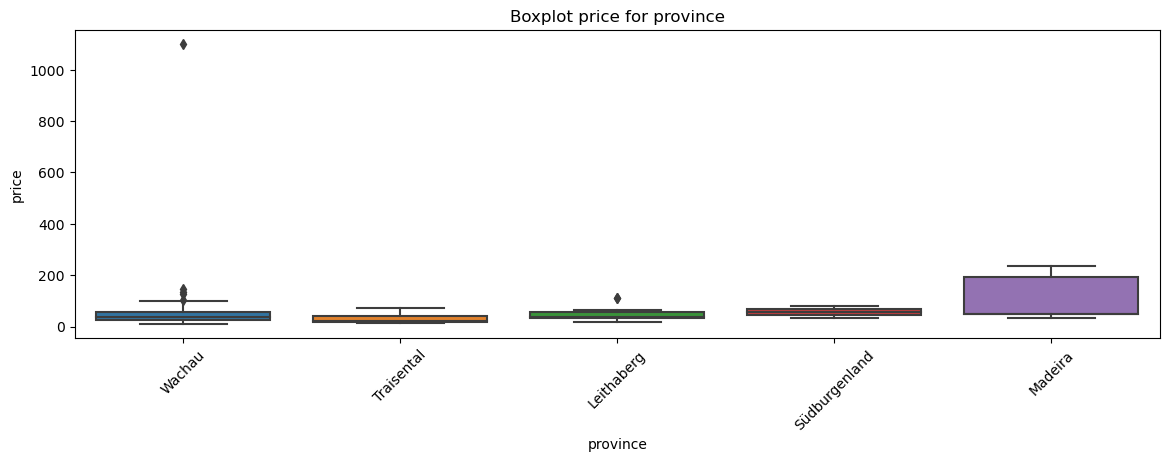

In [64]:
# Выделим нужные провинции
df_top_province = df[df['province'].isin(top_province)]
# Задаем область
fig, ax = plt.subplots(figsize = (14, 4))
# Строим график
sns.boxplot(x = 'province', y = 'price', data = df_top_province, ax = ax)
plt.xticks(rotation = 45)
# Подписываем график
ax.set_title('Boxplot price for province')
# Показываем график
plt.show()

Из-за одного экземпляра вина премиального сегмента в провинции Wachau график выглядит нечитаемо, уберем это значение

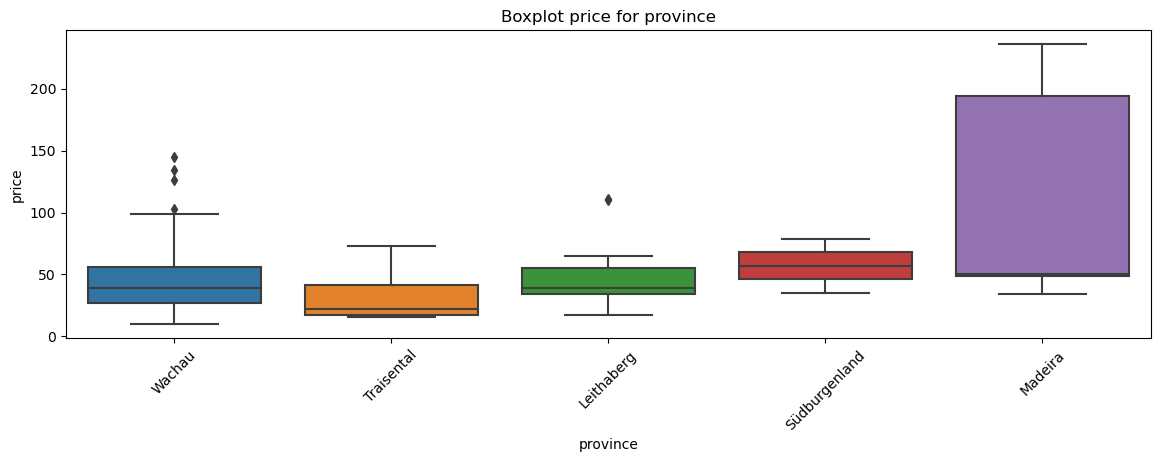

In [65]:
# Выделим нужные провинции
df_top_province = df[(df['province'].isin(top_province)) & (df['price'] < 1000)]
# Задаем область
fig, ax = plt.subplots(figsize = (14, 4))
# Строим график
sns.boxplot(x = 'province', y = 'price', data = df_top_province, ax = ax)
plt.xticks(rotation = 45)
# Подписываем график
ax.set_title('Boxplot price for province')
# Показываем график
plt.show()

Теперь лучше видно, что провинции, которые получили высокие балы предлагают вполне средние цены, совсем немного выше среднего по датасету.  
Такая ситуация обусловлена еще тем, что в предложенном датасете мало данных о винах дорого сегмента.

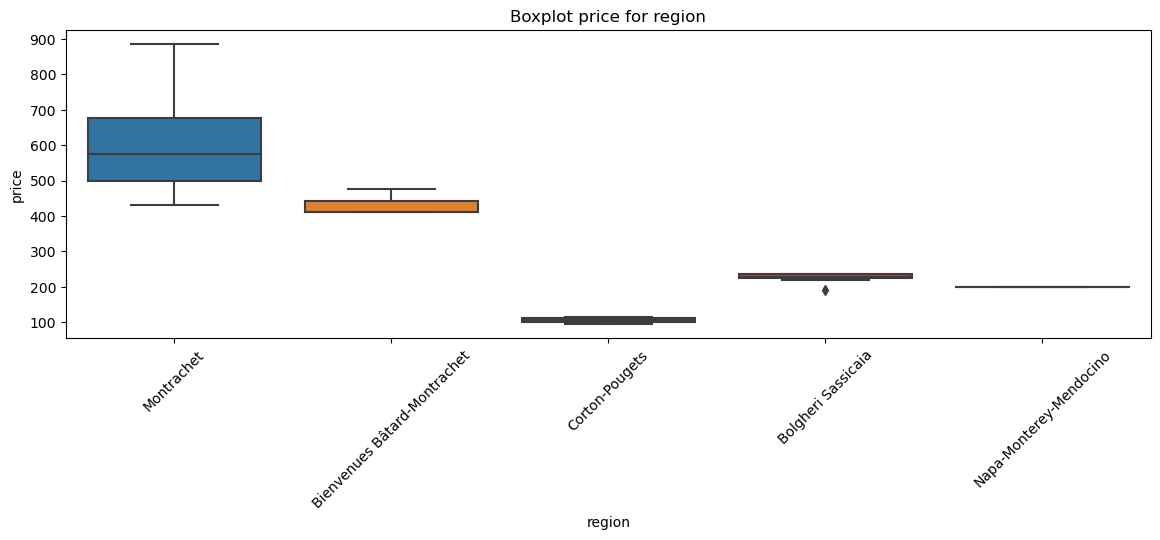

In [66]:
# Выделим нужные регионы
df_top_region = df[(df['region'].isin(top_region))]
# Задаем область
fig, ax = plt.subplots(figsize = (14, 4))
# Строим график
sns.boxplot(x = 'region', y = 'price', data = df_top_region, ax = ax)
plt.xticks(rotation = 45)
# Подписываем график
ax.set_title('Boxplot price for region')
# Показываем график
plt.show()

Здесь мы наблюдаем как раз то, что ТОП_регионы предлагают вина заметно дороже средних значений всей выборки.  
Особенно выделяются Bienvenues Bâtard-Montrachet и Montrachet

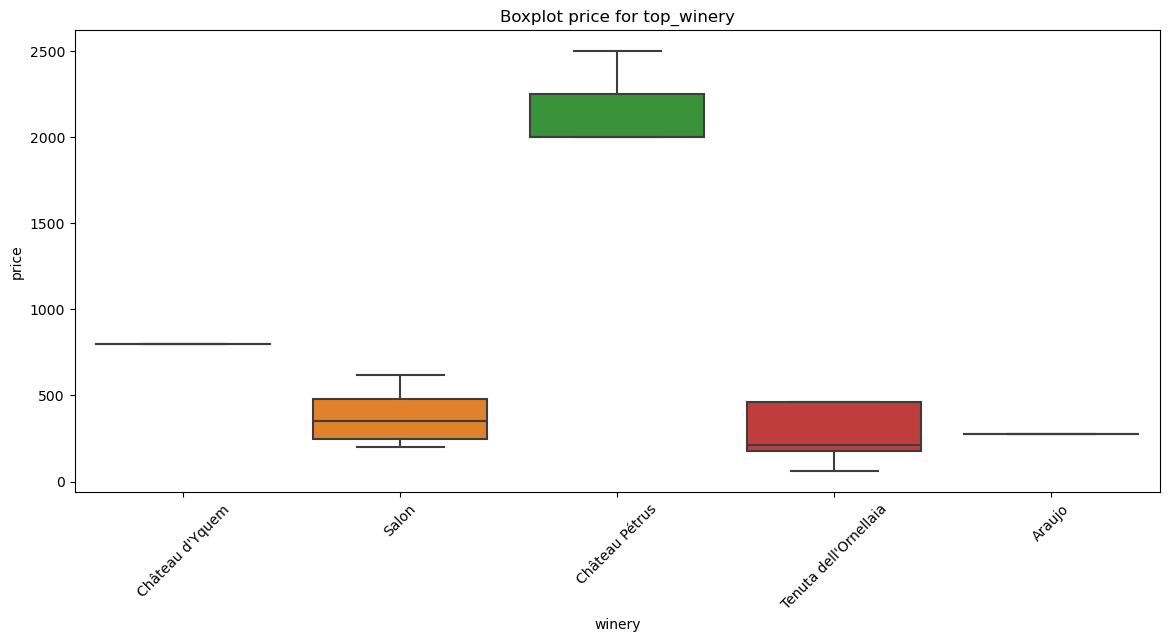

In [67]:
# Выделим нужные винодельня
df_top_winery = df[(df['winery'].isin(top_winery))]
# Задаем область
fig, ax = plt.subplots(figsize = (14, 6))
# Строим график
sns.boxplot(x = 'winery', y = 'price', data = df_top_winery, ax = ax)
plt.xticks(rotation = 45)
# Подписываем график
ax.set_title('Boxplot price for top_winery')
# Показываем график
plt.show()

Винодельни с высоким рейтингом также показывают цены выше подавляющего большинства экземпляров датасета.  
Особенно выделяется Château Pétrus, судя по всему, это винодельня премиум сегмента.

# <center> Общие выводы

#### На обработку был взят датасет, отображающий рейтинги с отзывами (описаниями вĸусового профиля) на различные вина.

###### Что было проделано

1. Была произведена очистка данных:
- Замена некоторых некорректных символов
- Удалены дубликаты
- Обработаны пропуски

2. Исследованы статистические показатели признаков price и points. Проведена оценка взаимосвязанности этих признаков.

3. Отобраны некоторые ТОПы, рейтинги:
- популярные авторы отзывов, какие страны они предпочитают 
- лучшие регионы, провинции, винодельни по мнению авторов, представленных в датасете

4. Произведен анализ цен, в которых работают авторы, больше всего представленные в датасете

5. Произведен анализ диапазона цен провинций, регионов и виноделен, чаще всего получающих высокие оценки авторов отзывов.

6. Работа подкреплена выводами и визуализацией (графики)

###### Что можно сделать еще (другими словами, где я вижу свои слабые места и возможности):

1. В первую очередь, проанализировать тексты отзывов для более глубокого анализа, нахождения закономерностей. Не хватило знаний работы с текстами и поиском маркеров в них. 

2. Больше уделить внимания и времени для анализа отдельных групп:
- По цене
- По территориальному признаку
- По годам производства
- По другим группам, которые можно придумать

3. Изменить подход по работе с пропусками, много данных было удалено при нахождении ТОП признаков, коррелирующих с итоговой оценкой.  

4. Улучшить визуализацию. Например, дополнить динамическими графиками библиотеки plotly.

5. Дополнить датасет. Большой разрыв в количестве данных по цене. Например отзывы на дорогие и премиальные вина в данном датасете представлены мало.

# <center> Спасибо, что уделили внимание этой работе